In [241]:
%matplotlib inline


# Filtragem no domínio da frequência


Vamos retirar o ruído de uma imagem usando filtragem em frequência. Para isso, vamos usar o teorema da convolução:


\begin{align}f(t)*g(t) \Leftrightarrow F(u)G(u)\end{align}





Leitura da imagem original
###########################################################



In [242]:
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage import color, data
from scipy import fftpack

# Funcoes auxiliares

def preencher(matriz, linhas=-1, colunas=-1):
    """Cria uma nova matriz, de dimensoes maiores que a matriz passada como entrada, e preenchendo os novos
    elementos com zero."""
    rows, cols = matriz.shape
    if(linhas < 0 and colunas < 0):
        linhas, colunas = (2*rows, 2*cols)
    if(rows > linhas or cols > colunas):
        raise ValueError("Novas dimensões (%d, %d) são menores que as anteriores (%d, %d)" % (linhas, colunas, rows, cols))
    res = np.zeros((linhas, colunas), dtype=matriz.dtype)
    res[0:rows, 0:cols] = matriz
    return res

def mostra_imagem_cinza(data, tamanho=(7,7)):
  """Uma função auxiliar para exibir uma imagem em níveis de cinza"""
  #f = plt.figure(figsize=(7,7))
  f = plt.figure(figsize=tamanho)  
  ax_img = f.gca()
  ax_img.imshow(data, cmap=plt.cm.gray, interpolation='none')
  ax_img.set_axis_off()
  return (f, ax_img)

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), cmap='PuBu_r', norm=LogNorm(vmin=5))
    plt.colorbar()
    
def filtro_passa_baixa(dimensao, raio=0.1):
    filtro = np.zeros((dimensao, dimensao), dtype=float)
    xidx = np.arange(dimensao)
    yidx = np.arange(dimensao)
    semidim = dimensao/2
    x0, y0 = dimensao//2, dimensao//2
    xx, yy = np.meshgrid(xidx, yidx, indexing='ij')
    grade = np.sqrt(((xx-x0)**2 + (yy-y0)**2))/semidim < raio
    filtro[grade] = 1
    return filtro

def deslocamento_freq(rows, cols):
    xidx = np.arange(rows)
    yidx = np.arange(cols)
    xx, yy = np.meshgrid(xidx, yidx, indexing='ij')
    grade = -np.ones((rows, cols))
    # em python a**b significa "a elevado a b"
    mascara = grade**(xx+yy)
    return mascara


Vamos ler e mostrar a imagem:

Dimensoes:
474 linhas, 630 colunas


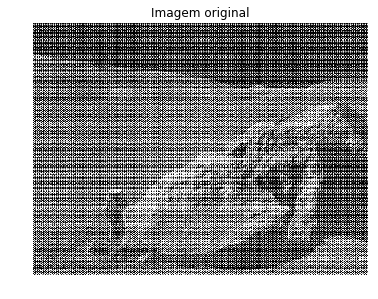

In [243]:
im = plt.imread('./imagens/moonlanding.png').astype(float)
linhas, colunas = im.shape

f, ax = mostra_imagem_cinza(im, tamanho=(6, 6))
ax.set_title('Imagem original')
rows, cols = im.shape
print("Dimensoes:")
print("%d linhas, %d colunas" % (rows, cols))




Os algoritmos de transformada de Fourier são mais eficientes quando as dimensões de entrada (número de linhas, colunas)  são potências de 2. Por isso, é comum preencher a imagem com zeros, até que o número de linhas e colunas seja uma potência de 2.

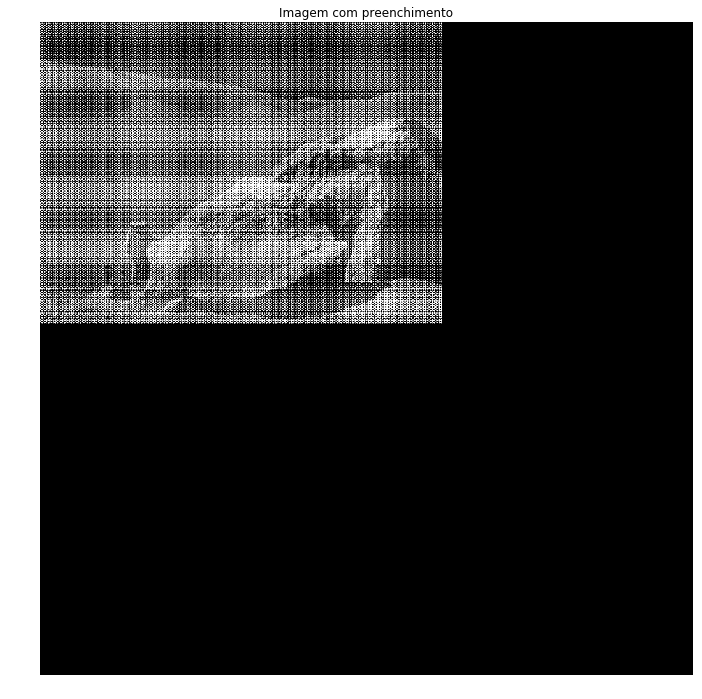

In [244]:
impad = preencher(im, 1024, 1024)

f, ax = mostra_imagem_cinza(impad, tamanho=(12, 12))
ax.set_title('Imagem com preenchimento');

Calculamos a transformada de Fourier 2D da imagem:



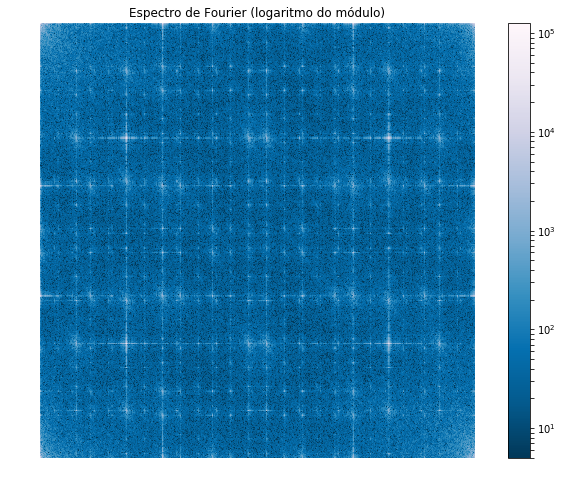

In [245]:
im_fft = fftpack.fft2(impad)

f = plt.figure(figsize=(12, 8))
f.gca().set_axis_off()
plot_spectrum(im_fft)
plt.title('Espectro de Fourier (logaritmo do módulo)');

Se aplicarmos a transformada de Fourier diretamente, como acima, o componente de frequências (0, 0) ficará na posição (0, 0) da imagem resultante (canto superior esquerdo). Para visualização, é mais conveniente posicionar o componente (0, 0) no centro da imagem de espectro. Para isso, aplicamos um operador de deslocamento em frequência na imagem antes da transformação. 
Se multiplicarmos cada pixel da imagem $f(x, y)$ por $(-1)^{(x + y)}$, produziremos um deslocamento horizontal + vetical equivalente a metade das dimensões da imagem.


Mascara de deslocamento (primeiras 5 linhas/colunas):
[[ 1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1.]]


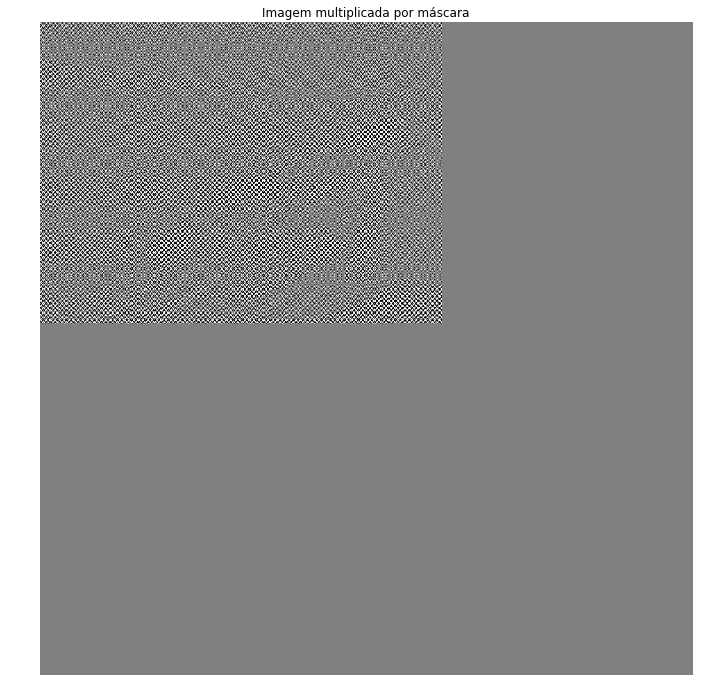

In [246]:
rows, cols = impad.shape
xidx = np.arange(rows)
yidx = np.arange(cols)
xx, yy = np.meshgrid(xidx, yidx, indexing='ij')
grade = -np.ones((rows, cols))
# em python a**b significa "a elevado a b"
mascara_deslocamento = grade**(xx+yy)
print('Mascara de deslocamento (primeiras 5 linhas/colunas):')
print(mascara_deslocamento[0:5, 0:5]);

im_desloca = impad*mascara_deslocamento

f, ax = mostra_imagem_cinza(im_desloca, tamanho=(12, 12))
ax.set_title('Imagem multiplicada por máscara');


Agora podemos fazer a transformada da imagem, com deslocamento em frequência. Compare com o resultado anterior.

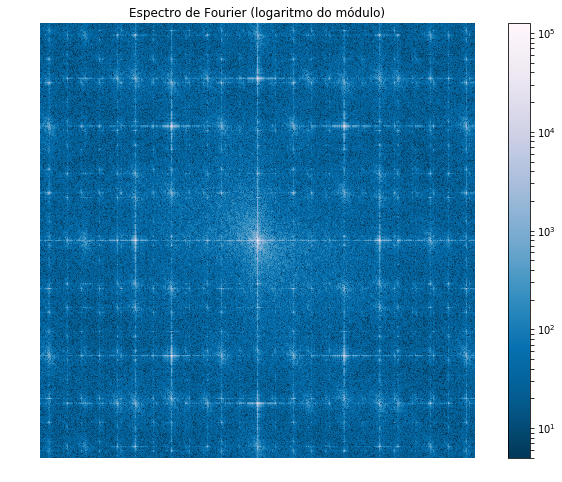

In [247]:
im_fft_centralizada = fftpack.fft2(im_desloca)

f = plt.figure(figsize=(12, 8))
f.gca().set_axis_off()
plot_spectrum(im_fft_centralizada)
plt.title('Espectro de Fourier (logaritmo do módulo)');

Agora vamos criar uma máscara de filtro em frequência, do tipo *passa-baixa*. Isto é, o filtro produz uma saída que conserva as frequências mais baixas da imagem original e ao mesmo tempo barra a passagem das frequências mais altas. De acordo com o teorema da convolução, a máscara do filtro será multiplicada pela imagem de entrada. Vamos começar gerando uma máscara com as mesmas dimensões da imagem que desejamos filtrar.

A máscara de filtro que vamos implementar apresenta valor $1$ para frequências mais baixas (próximas do centro da máscara) e valor $0$ para as frequências mais altas (próximas da borda da máscara). Vamos controlar o formato do filtro usando um parâmetro ``raio'', $0 < \text{raio} < 1$.

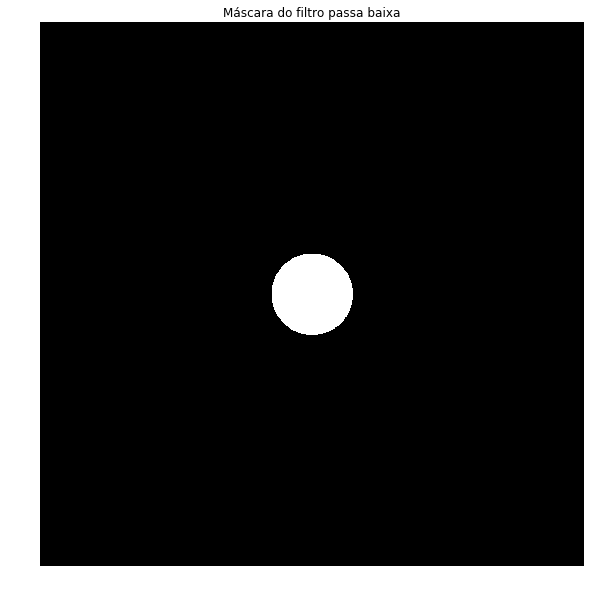

In [248]:
fpb = filtro_passa_baixa(1024, 0.15)
f, ax = mostra_imagem_cinza(fpb, tamanho=(10,10))
ax.set_title('Máscara do filtro passa baixa');

Se multiplicarmos a máscara do filtro pela transformada de Fourier, vamos obter um efeito de bloquear as frequências mais altas (**atenção, essa ainda não é a maneira mais correta de realizar a filtragem**).

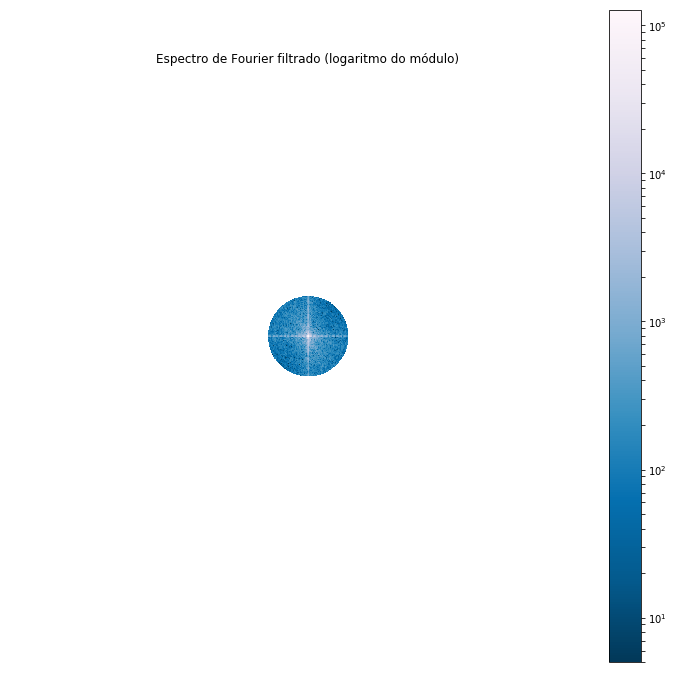

In [249]:
fft_fpb = fpb*im_fft_centralizada
f = plt.figure(figsize=(12, 12))
f.gca().set_axis_off()
plot_spectrum(fft_fpb)
plt.title('Espectro de Fourier filtrado (logaritmo do módulo)');

Podemos observar o efeito desse filtro se aplicarmos a transformada de Fourier inversa. Como nós aplicamos o operador de descolamento em frequência na imagem original, precisamos inverter o efeito depois de aplicar a transformada inversa.

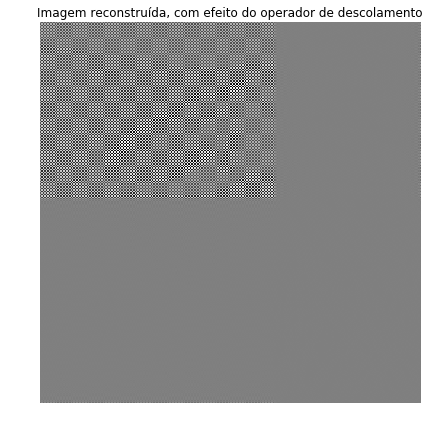

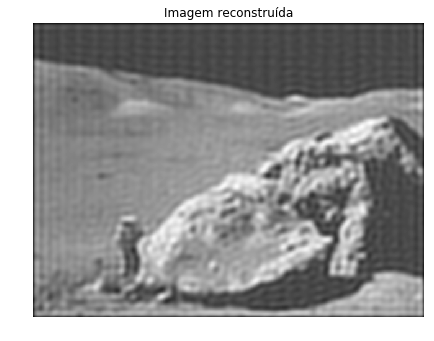

In [250]:
# aplicando a transformada inversa
# desprezamos a parte imaginária
im_filtrada_desloca = fftpack.ifft2(fft_fpb).real

f, ax = mostra_imagem_cinza(im_filtrada_desloca)
ax.set_title('Imagem reconstruída, com efeito do operador de descolamento');

im_filtrada = im_filtrada_desloca*mascara_deslocamento

f, ax = mostra_imagem_cinza(im_filtrada[0:linhas, 0:colunas])
ax.set_title('Imagem reconstruída');

Infelizmente, se a filtragem for aplicada de maneira direta, como no procedimento acima, podem acontecer distorções devido a efeitos de borda da imagem. De fato, a multiplicação de funções discreta no domínio da frequência corresponde a uma convolução *circular*. O efeito resultante é equivalente a uma convolução no domínio do espaço em que a imagem fosse replicada ao longo do plano (pense em azulejos em uma parede). 

Para corrigir esse efeito, é preciso preencher tanto a imagem quanto o filtro com zeros, criando uma borda externa formada por zeros. 

Primeiro, vamos preparar a máscara do filtro. 

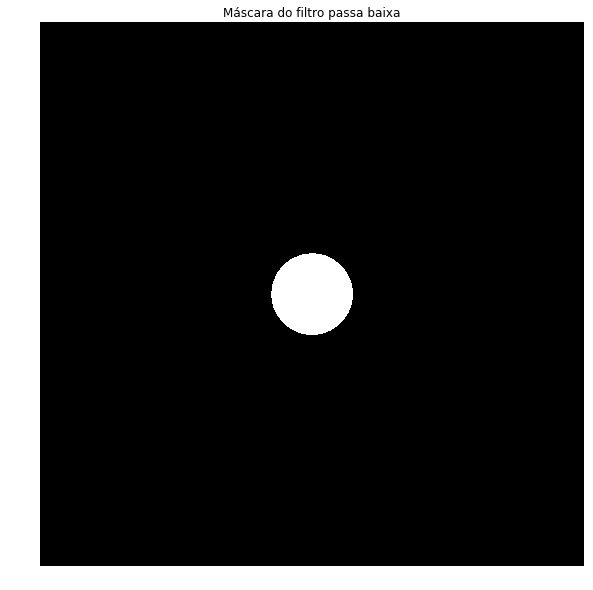

In [251]:
fpb_dobro = filtro_passa_baixa(2048, 0.15)

f, ax = mostra_imagem_cinza(np.abs(fpb_dobro), tamanho=(10,10))
ax.set_title('Máscara do filtro passa baixa');


Agora vamos preparar a imagem. Primeiro vamos preencher a imagem até a dimensão do filtro (2048x2048). Aplicamos um operador de deslocamento e fazemos a transformada de Fourier do resultado:

[[ 1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1.]
 [-1.  1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1.]]


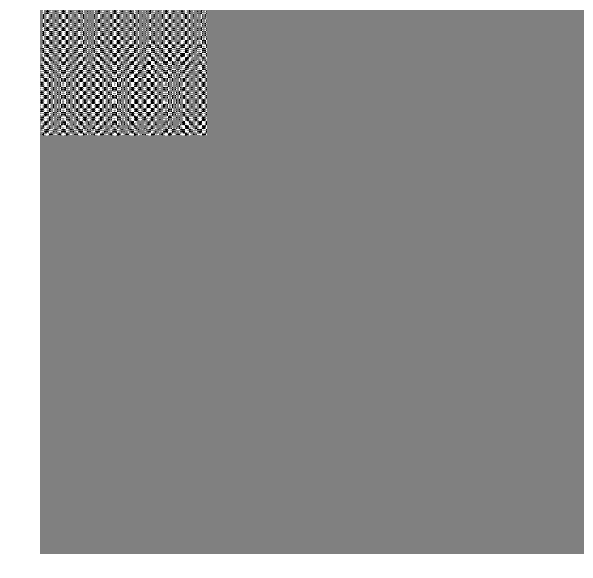

In [252]:
im2048 = preencher(im, 2048, 2048)
mascara2048 = deslocamento_freq(2048, 2048)
im2048desloca = im2048*mascara2048;
f, ax = mostra_imagem_cinza(im2048desloca, tamanho=(10,10))

(2048, 2048)


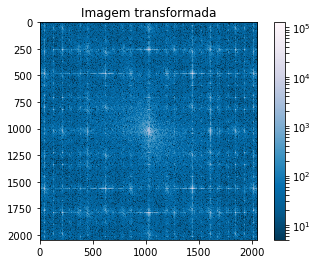

In [253]:
im_fft2048 = fftpack.fft2(im2048desloca)

plot_spectrum(im_fft2048)
print(im_fft2048.shape)
plt.title('Imagem transformada');

Agora podemos fazer o produto entre máscara e imagem transformada.

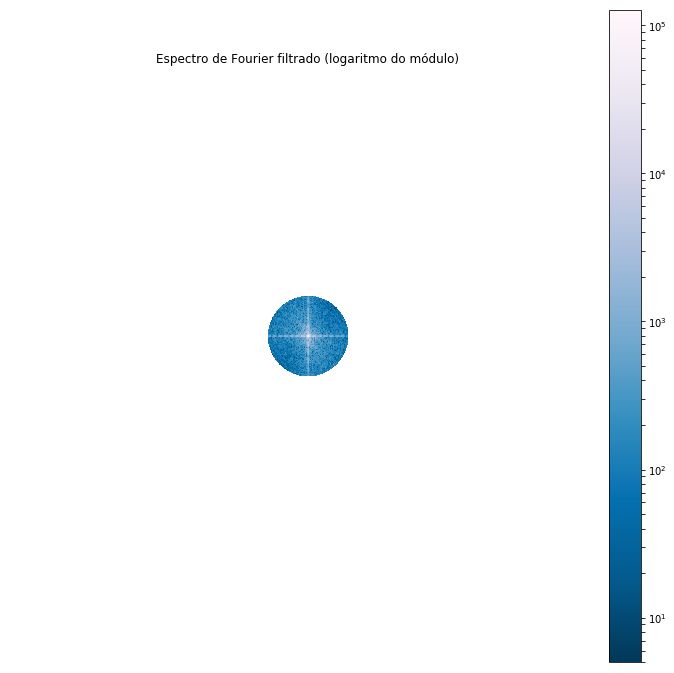

In [254]:
fft_fpb2048 = fpb_dobro*im_fft2048
f = plt.figure(figsize=(12, 12))
f.gca().set_axis_off()
plot_spectrum(fft_fpb2048)
plt.title('Espectro de Fourier filtrado (logaritmo do módulo)');

Valor quadrático médio da diferenca:  1.37389602726e-06


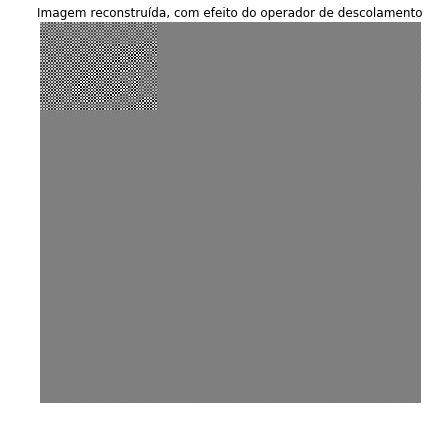

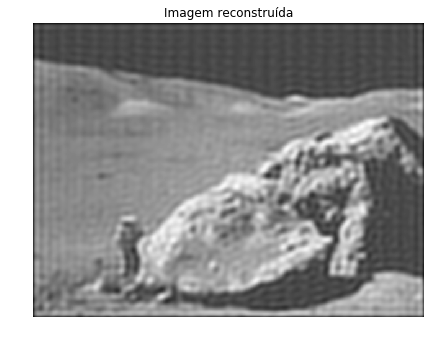

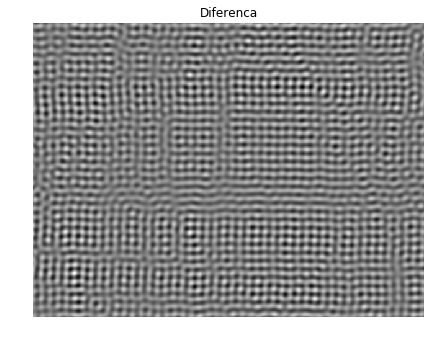

In [258]:
# aplicando a transformada inversa
# desprezamos a parte imaginária
im_filtrada_desloca2048 = fftpack.ifft2(fft_fpb2048).real

f, ax = mostra_imagem_cinza(im_filtrada_desloca2048)
ax.set_title('Imagem reconstruída, com efeito do operador de descolamento');

im_filtrada2048 = im_filtrada_desloca2048*mascara2048

f, ax = mostra_imagem_cinza(im_filtrada2048[0:linhas, 0:colunas])
ax.set_title('Imagem reconstruída');

diferenca = im_filtrada2048[0:linhas, 0:colunas] - im_filtrada[0:linhas, 0:colunas]
f, ax = mostra_imagem_cinza(diferenca)
ax.set_title('Diferenca');

rms_diff = (diferenca*diferenca).mean()
print("Valor quadrático médio da diferenca: ", rms_diff)